In [1]:
import cv2
import os
import sys
import numpy as np 
import pandas as pd 
import tensorflow as tf 
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import glob
from PIL import Image

Using TensorFlow backend.


In [2]:
raw_path = r'C:\Users\NDH60042\MAJOR PROJECT\New Dataset'

In [4]:
read = lambda imname: np.asarray(Image.open(imname).convert("RGB").resize((224,224)))

In [5]:
# Enter Directory of all images 
data = []
label = []
for folder in os.listdir(raw_path):
    img_dir = os.path.join(raw_path,folder)
    data_path = os.path.join(img_dir,'*g')
    files = glob.glob(data_path)
    
    for f1 in files:
        ims = [read(f1)]
        data += ims
        label.append(folder)

img_array = np.array(data , dtype = 'uint8')

In [3]:
class_name = []
no_images = []
for folder in os.listdir( raw_path ):
    class_name.append(folder)
    image_files = os.path.join(raw_path,folder)
    no_images.append(len(os.listdir(image_files)))
    

In [12]:
import matplotlib.pyplot as plt

In [13]:
plot_df = pd.DataFrame()
plot_df['Class'] = class_name
plot_df['Images'] = no_images

In [14]:
plot_df

,Class,Images
0,bookmagazine,1160
1,cardboard,1043
2,cutlery,758
3,electricaldevice,947
4,glass bottle,954
5,glass jar,970
6,metal cans,1196
7,newspaper,1132
8,paper,1159
9,plastic bag,881


<Figure size 2160x576 with 0 Axes>

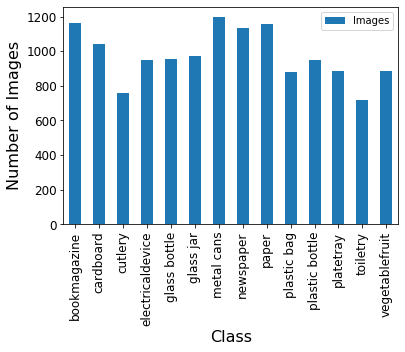

In [22]:
plt.figure(figsize=(30,8))
fig = plot_df.plot(x = 'Class', y = 'Images' , kind = 'bar')
fig.set_xlabel('Class', fontsize = 16)
fig.set_ylabel('Number of Images',fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

In [10]:
img_array.shape

(13634, 224, 224, 3)

In [11]:
len(label)

13634

In [12]:
onehot_encoder = OneHotEncoder(sparse=False)
labels_arr = np.array([[i] for i in label]).reshape(len(label),1)
labels_encoded = onehot_encoder.fit_transform(labels_arr)

np.random.seed(2)

In [13]:
labels_encoded.shape

(13634, 14)

In [14]:
train_X, validation_X, train_y, validation_y = train_test_split(img_array , labels_encoded , test_size = 0.25)

In [15]:
train_X.shape

(10225, 224, 224, 3)

In [16]:
validation_X.shape

(3409, 224, 224, 3)

In [17]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>0.9995):
            print("\nReached 99.95% accuracy so cancelling training!")
            self.model.stop_training = True

In [18]:
from keras.applications.resnet50 import ResNet50

conv_base = ResNet50(weights = 'imagenet', include_top = False, input_shape = (224,224,3))

C:\Users\NDH60042\AppData\Local\Continuum\anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [19]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dense(len(labels_encoded[0]),activation = 'softmax'))

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dense_2 (Dense)              (None, 14)                3598      
Total params: 49,281,678
Trainable params: 49,228,558
Non-trainable params: 53,120
_________________________________________________________________


In [21]:
len(model.trainable_weights)
conv_base.trainable = False
len(model.trainable_weights)

4

In [48]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dense_2 (Dense)              (None, 14)                3598      
Total params: 49,281,678
Trainable params: 25,693,966
Non-trainable params: 23,587,712
_________________________________________________________________


In [22]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
from keras.preprocessing.image import ImageDataGenerator

In [24]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)
test_datagen = ImageDataGenerator(
    rescale=1/255,
)


batch_size = 32

In [25]:
# import os
# labels_count = dict()
# for img_class in [ic for ic in os.listdir(raw_path) ]:
#     labels_count[img_class] = len(os.listdir(raw_path + '/' + img_class))
# total_count = sum(labels_count.values())
# class_weights = {cls: total_count / count for cls, count in 
#                  enumerate(labels_count.values())}


In [26]:
# class_weights

In [41]:
model.fit_generator(
    datagen.flow(train_X,train_y),
    steps_per_epoch=len(train_X) // batch_size,
    epochs=10,
    validation_data=(validation_X,validation_y),
    validation_steps=len(validation_X) // batch_size
)

Epoch 1/10
319/319 [==============================] - 3804s 12s/step - loss: 2.7482 - accuracy: 0.5475 - val_loss: 1.5930 - val_accuracy: 0.6016
Epoch 2/10
319/319 [==============================] - 3508s 11s/step - loss: 1.1299 - accuracy: 0.6797 - val_loss: 1.3779 - val_accuracy: 0.6307
Epoch 3/10
319/319 [==============================] - 3487s 11s/step - loss: 1.0113 - accuracy: 0.7090 - val_loss: 1.2764 - val_accuracy: 0.6712
Epoch 4/10
319/319 [==============================] - 3488s 11s/step - loss: 0.8857 - accuracy: 0.7375 - val_loss: 1.2013 - val_accuracy: 0.6847
Epoch 5/10
319/319 [==============================] - 3489s 11s/step - loss: 0.7815 - accuracy: 0.7659 - val_loss: 1.3078 - val_accuracy: 0.6688
Epoch 6/10
319/319 [==============================] - 3484s 11s/step - loss: 0.7110 - accuracy: 0.7791 - val_loss: 1.3101 - val_accuracy: 0.6803
Epoch 7/10
319/319 [==============================] - 3509s 11s/step - loss: 0.6643 - accuracy: 0.7967 - val_loss: 1.1818 - val_ac

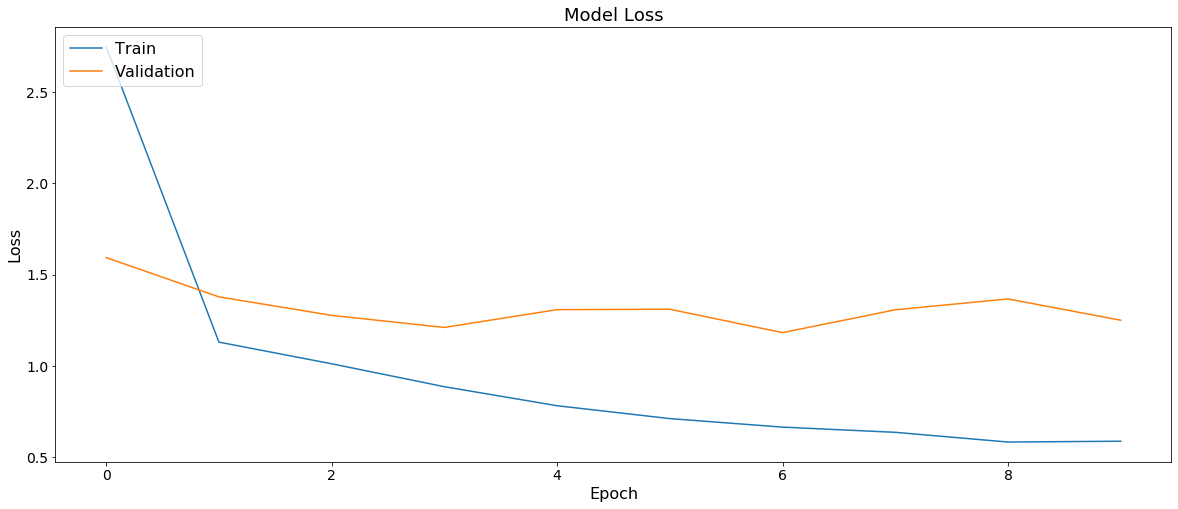

In [28]:
import matplotlib.pyplot as plt

#LOSS
train_loss = [2.7482,1.1299,1.0113,0.8857,0.7815,0.7110,0.6643,0.6358,0.5826,0.5871]
val_loss = [1.5930,1.3779,1.2764,1.2103,1.3078,1.3101,1.1818,1.3070,1.3664,1.2499]

plt.figure(figsize=(20,8))
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model Loss',fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('Loss',fontsize = 16)
plt.xlabel('Epoch',fontsize = 16)
plt.legend(['Train', 'Validation'], loc='upper left',fontsize = 16)
plt.show()


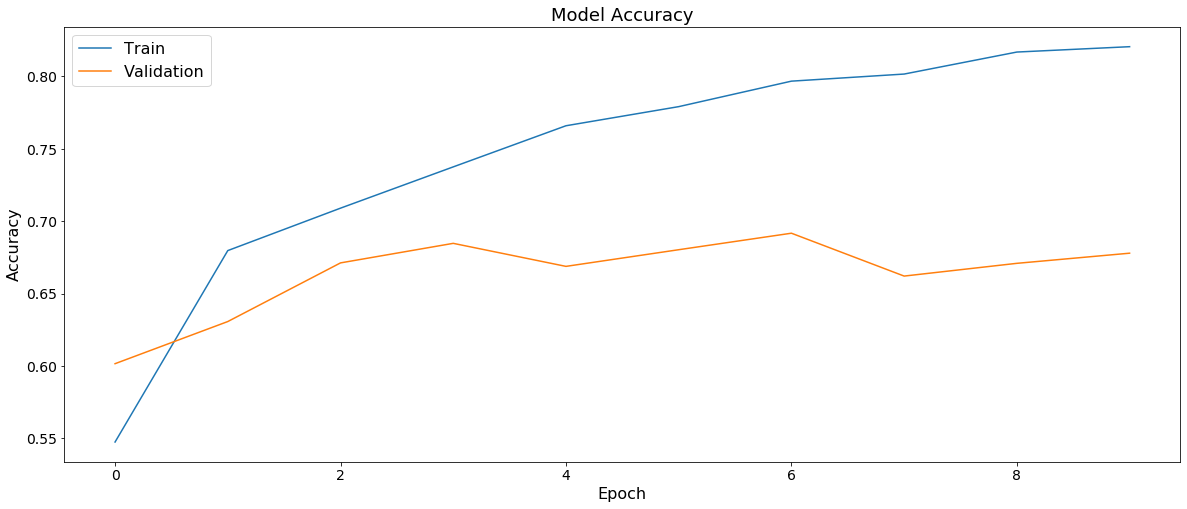

In [29]:
train_acc = [0.5475,0.6797,0.7090,0.7375,0.7659,0.7791,0.7967,0.8016,0.8168,0.8205]
val_acc = [0.6016,0.6307,0.6712,0.6847,0.6688,0.6803,0.6917,0.6621,0.6709,0.6779]

plt.figure(figsize=(20,8))
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model Accuracy',fontsize = 18)
plt.ylabel('Accuracy', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Epoch', fontsize = 16)
plt.legend(['Train', 'Validation'],loc='upper left',fontsize = 16)

In [42]:
model.save('ResNet.h5')

In [54]:
history = model

In [43]:
img_array.shape

(13634, 224, 224, 3)

In [45]:
waste_classes = {
    '0' : 'Book/Magazine',
    '1' : 'Cardboard',
    '2' : 'Cutlery/Utensils',
    '3' : 'Electrical Device',
    '4' : 'Glass Bottle',
    '5' : 'Glass Jar',
    '6' : 'Metal Cans',
    '7' : 'Newspaper',
    '8' : 'Paper',
    '9' : 'Plastic Bag',
    '10' : 'Plastic Bottle',
    '11' : 'Plate/ Tray',
    '12' : 'Toiletry',
    '13' : 'Vegetable/Fruit'
} 

In [66]:
video = cv2.VideoCapture(0)
final_result = ''
while True:
        _, frame = video.read()
 
        start_point = (160,160)
        end_point = (440,440)
        color =  (0,225,0)
        thickness = 2
        
        frame = cv2.rectangle(frame, start_point , end_point , color , thickness) 
        
        #Resizing into 224x224 because we trained the model with this image size and changing to RGB channel
        im = Image.fromarray(frame, 'RGB') 
        im = im.resize((224,224))
        img_array = np.array(im)

        #Our keras model used a 4D tensor, (images x height x width x channel)
        #So changing dimension 224x224x3 into 1x224x224x3 
        img_array = np.expand_dims(img_array, axis=0)

        #Calling the predict method on model
        prediction = model.predict(img_array)
        class_prediction = np.argmax(prediction, axis=1)
    
        answer = [v for k,v in waste_classes.items() if str(class_prediction[0]) == k][0]     
        cv2.putText(frame, answer, (50,50) , cv2.FONT_HERSHEY_SIMPLEX , 2 ,(255, 0, 0),
                2,  
                cv2.LINE_4)
        key=cv2.waitKey(1)
        
        # Press s only if you want to get DIY ideas 
        if key == ord('s'):
            cv2.imwrite(filename='saved_img.jpg', img=frame)
            img_new = cv2.imread('saved_img.jpg', cv2.IMREAD_GRAYSCALE)
            img_new = cv2.imshow("Captured Image", img_new)
            
            #Here we are storing the image whose DIY hacks we want to know in the testing folder, in a processed form
            print("Processing image...")
            img_ = cv2.imread('saved_img.jpg', cv2.IMREAD_ANYCOLOR)
            print("Resizing image to 224x224 scale...")
            img_ = cv2.resize(img_,(224,224))
            print("Resized...")
            img_resized = cv2.imwrite(filename=r'C:\Users\NDH60042\MAJOR PROJECT\test\saved_img-final.jpg', img=img_)
            print("Image saved!")
            
            #Here we are reading the image that just got stored in the test folder
            test_data = []
            testpath_ = r'C:\Users\NDH60042\MAJOR PROJECT\test'
            testdata_path = os.path.join(testpath_ ,'*g')
            test_files = glob.glob(testdata_path)
            for f in test_files:
                ims = [read(f)]
                test_data += ims
      
            test_array = np.array(test_data , dtype = 'uint8')
            
            #Predicting the class
            prediction = model.predict(test_array)
            class_prediction = np.argmax(prediction, axis = 1)
            
            answer = [v for k,v in waste_classes.items() if str(class_prediction[0]) == k][0]     
            
            cv2.putText(img_new, answer, (50,50) , cv2.FONT_HERSHEY_SIMPLEX , 2 ,(255, 0, 0),
                        2, cv2.LINE_4)
            
            #Storing the result whose DIY hacks we want
            final_result = answer
            cv2.waitKey(1650)
            cv2.destroyAllWindows()
            
            break

        cv2.imshow("video", frame)
       
        if key == ord('q'):
                break
video.release()
cv2.destroyAllWindows()

In [52]:
final_result

'Book/Magazine'

In [67]:
import pickle


In [69]:
filename = 'mainmodel.pkl'
pickle.dump(model,open(filename,'wb'))